Ce notebook a pour but d'évaluer les performances du modèle DenseNet121 fine-tuné à l'aide de plusieurs outils d'interprétation classiques en classification binaire : rapport de classification, matrice de confusion, courbe ROC, et AUC.

In [1]:
!{sys.executable} -m pip install scikit-learn


'{sys.executable}' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


On commence par recharger le modèle sauvegardé précédemment, ainsi que l’ensemble de test depuis le disque.
Les images sont chargées dans un image_dataset_from_directory, en mode non mélangé (shuffle=False) afin de pouvoir faire correspondre les images aux prédictions.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Rechargement du modèle sauvegardé
model = load_model("models/densenet_model.keras")

# Rechargement du dataset de test
data_dir = Path("C:/WorkBench/Data/Projet/ZOIDBERG2.0/Travail/Data")
test_dir = data_dir / "test"

img_size = (224, 224)
batch_size = 32
seed = 42

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,  # Important pour correspondre à l’ordre des labels
    label_mode='binary'
)


Found 1050 files belonging to 2 classes.


c:\Users\Adnane\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Récupérer les vraies étiquettes
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Prédictions 
y_prob = model.predict(test_dataset, verbose=1).ravel()

# Binariser les prédictions 
y_pred = (y_prob >= 0.5).astype(int)


33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


À partir des prédictions du modèle sur le jeu de test, on évalue les performances à l’aide des métriques suivantes :

    Accuracy (précision globale)

    Precision (taux de vrais positifs parmi les positifs prédits)

    Recall (taux de vrais positifs parmi les vrais positifs réels)

    F1-score (moyenne harmonique de la précision et du rappel)

Ces résultats sont affichés dans un tableau récapitulatif appelé rapport de classification

La matrice de confusion permet de visualiser les erreurs de classification du modèle.
On peut ainsi identifier :

    Les vrais positifs (PNEUMONIA bien détectés),

    Les faux négatifs (PNEUMONIA non détectés),

    Les faux positifs (NORMAL classés à tort comme PNEUMONIA),

    Les vrais négatifs (NORMAL bien détectés).

Elle donne une idée plus fine que l’accuracy seule, surtout dans le cas de classes déséquilibrées.

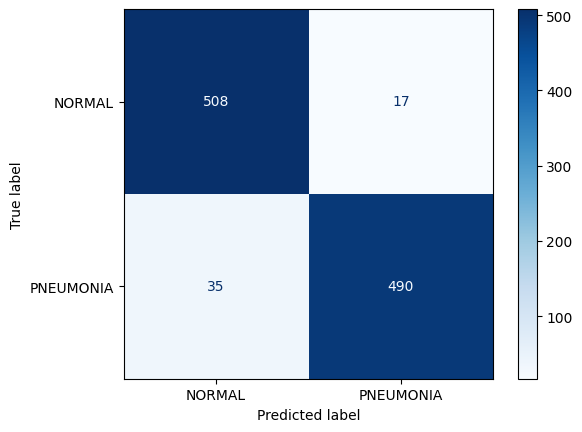

              precision    recall  f1-score   support

      NORMAL       0.94      0.97      0.95       525
   PNEUMONIA       0.97      0.93      0.95       525

    accuracy                           0.95      1050
   macro avg       0.95      0.95      0.95      1050
weighted avg       0.95      0.95      0.95      1050



In [4]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


La courbe ROC (Receiver Operating Characteristic) trace la courbe entre le taux de faux positifs (FPR) et le taux de vrais positifs (TPR) en faisant varier le seuil de classification.

L’AUC (Area Under Curve) mesure la capacité du modèle à distinguer les deux classes :

    Une AUC proche de 1.0 indique une excellente séparation.

    Une AUC proche de 0.5 signifie que le modèle n'est pas meilleur qu’un choix aléatoire.

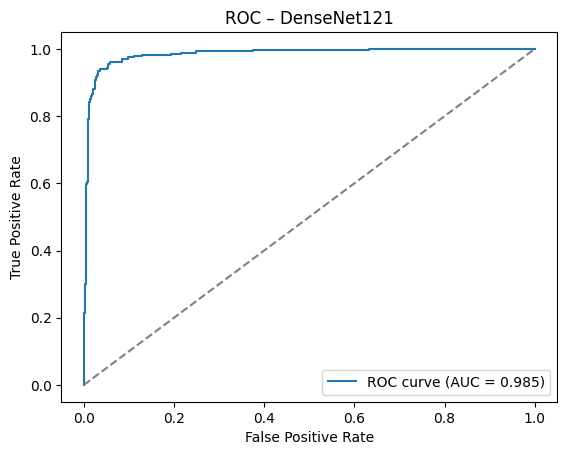

In [5]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – DenseNet121")
plt.legend()
plt.show()


Les résultats affichés (accuracy, F1-score, AUC) indiquent que le modèle est performant, en particulier sur la tâche de détection de la pneumonie à partir d’images de radiographie.
La matrice de confusion montre un bon équilibre entre les erreurs, et la courbe ROC révèle une grande capacité de discrimination du modèle.